<a href="https://colab.research.google.com/github/Olivia-Feldman/NUGAN-DISTGAN/blob/Olivia/DIST_GAN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import time
import matplotlib.pyplot as plt
from math import floor



In [28]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [30]:
class Net(nn.Module):
    def __init__(self, input_dim=1, output_dim=10, input_size=28, base_size=64):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size
        # self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.conv2 = nn.Conv2d(16, 128, kernel_size=3, stride=1, padding=1)
        # self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        # self.fc1 = nn.Linear(128 * 8 * 8, 512)
        # self.fc2 = nn.Linear(512, 128)
        # self.fc3 = nn.Linear(128, 10)

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.ReLU(),
        )

        #initialize_weights(self)

    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = F.relu(self.conv3(x))
        # x = x.view(-1, 128 * 8 * 8)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        x = self.conv(x)
        x = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)
        return x

In [31]:
class Classifier():
    def __init__(self, epoch=20, batch_size=500):

        self.epoch_range = epoch
        self.batch_size = batch_size
        valid_ratio = 0.3

        nb_train = int((1.0 - valid_ratio) * len(train_dataset))
        nb_valid =  int(valid_ratio * len(train_dataset))
        train_split_dataset, valid_split_dataset = torch.utils.data.dataset.random_split(train_dataset, [nb_train, nb_valid])

        self.trainloader = torch.utils.data.DataLoader(train_split_dataset, batch_size=self.batch_size,
                                          shuffle=True)
        self.validloader = torch.utils.data.DataLoader(valid_split_dataset, batch_size=self.batch_size,
                                          shuffle=True)
        self.testloader = torch.utils.data.DataLoader(test_dataset, 
                                        batch_size=self.batch_size, 
                                        shuffle=False,
                                        num_workers=1)

        self.net = Net().cuda()

        self.criterion = nn.CrossEntropyLoss().cuda()

        self.optimizer = optim.Adam(self.net.parameters(), lr=0.00146)

        from google.colab import drive
        drive.mount('/content/drive')
        self.PATH = 'cifar10_net_test_3.pth'


        # Function to train the CNN classifier
#--------------------------------------------------------------------------------------------------------

    def train(self):

        self.training_loss = []
        self.validation_loss = []

        start_time = time.time()
        best_loss = np.float('inf')
        for epoch in range(self.epoch_range): 

            running_loss = 0.0
            for i, data in enumerate(self.trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                # inputs, labels = data[0].to(device), data[1].to(device)
                inputs, labels = data[0].cuda(), data[1].cuda()

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()

            epoch_loss = running_loss / (i+1)
            self.training_loss.append(epoch_loss)
            print("Epoch: ", epoch, " train loss: ", '%.3f' % epoch_loss)

            #---------------------------------

            with torch.no_grad(): 
                running_loss = 0.0

                for i, data in enumerate(self.validloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    #inputs, labels = data[0].to(device), data[1].to(device)
                    inputs, labels = data[0].cuda(), data[1].cuda()

                    # forward 
                    outputs = self.net(inputs)
                    loss = self.criterion(outputs, labels)

                    # print statistics
                    running_loss += loss.item()


                epoch_loss = running_loss / (i+1)
                self.validation_loss.append(epoch_loss)
                print("Epoch: ", epoch, " validation loss: ", '%.3f' % epoch_loss)

                # save the best model based on validation loss
                if epoch_loss < best_loss:
                    torch.save(self.net.state_dict(), self.PATH)
                    best_loss = epoch_loss

        time_elap = (time.time() - start_time) // 60
        print('Finished Training in %d mins' % time_elap)

        plt.plot(range(self.epoch_range), self.training_loss, 'k-')
        plt.title('train loss vs. epoch')
        plt.xlabel('epoch')
        plt.ylabel('train_loss')
        plt.show()

        plt.plot(range(self.epoch_range), self.validation_loss, 'k-')
        plt.title('validation loss vs. epoch')
        plt.xlabel('epoch')
        plt.ylabel('validation_loss')
        plt.show()


    def test_accuracy(self):

        correct = 0
        total = 0

        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                outputs = self.net(images.cuda())
                #print("Outputs shape:", outputs.shape)
                _, predicted = torch.max(outputs.data, 1)
                #print("predicted:", predicted.shape)
                total += labels.size(0)
                correct += (predicted == labels.cuda()).sum().item()

        print('Accuracy of the network on the 10000 test images: %.3F %%' % (
            100 * correct / total))


Mounted at /content/drive
Epoch:  0  train loss:  0.218
Epoch:  0  validation loss:  0.082
Epoch:  1  train loss:  0.057
Epoch:  1  validation loss:  0.060
Epoch:  2  train loss:  0.037
Epoch:  2  validation loss:  0.066
Epoch:  3  train loss:  0.026
Epoch:  3  validation loss:  0.049
Epoch:  4  train loss:  0.017
Epoch:  4  validation loss:  0.048
Epoch:  5  train loss:  0.014
Epoch:  5  validation loss:  0.046
Epoch:  6  train loss:  0.011
Epoch:  6  validation loss:  0.048
Epoch:  7  train loss:  0.007
Epoch:  7  validation loss:  0.046
Epoch:  8  train loss:  0.006
Epoch:  8  validation loss:  0.048
Epoch:  9  train loss:  0.006
Epoch:  9  validation loss:  0.052
Epoch:  10  train loss:  0.007
Epoch:  10  validation loss:  0.052
Epoch:  11  train loss:  0.009
Epoch:  11  validation loss:  0.060
Epoch:  12  train loss:  0.007
Epoch:  12  validation loss:  0.053
Epoch:  13  train loss:  0.005
Epoch:  13  validation loss:  0.053
Epoch:  14  train loss:  0.005
Epoch:  14  validation lo

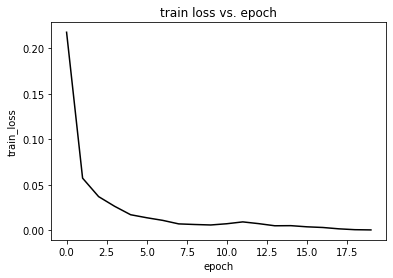

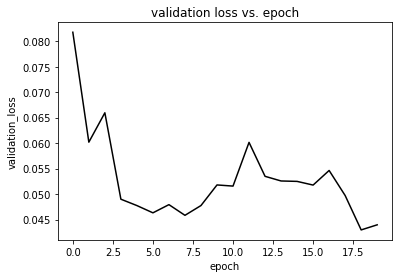

In [32]:
classifier = Classifier()
classifier.train()

In [33]:


def visualize_results(gan):
      sample_z_ = torch.rand((10, gan.z_dim)).cuda()
      samples = gan.G(sample_z_)
      samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
      samples = (samples + 1) / 2
      plt.figure(figsize=((1,10)))
      fig,ax = plt.subplots(1,10)
      for i in range(10):
          s=ax[i].imshow(np.squeeze(samples[i,]))
          s=ax[i].get_xaxis().set_visible(False)
          s=ax[i].get_yaxis().set_visible(False)
      s=plt.show()

In [34]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [35]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder,self).__init__()
        c =64
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=1)
        self.bn1 = nn.BatchNorm2d(c)
        self.bn2 = nn.BatchNorm2d(c*2)
        initialize_weights(self)   
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        return x

In [36]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, input_size=28, base_size=64):
        super(Generator, self).__init__()  
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = 28
        self.base_size = base_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(2*self.base_size, self.base_size, 4, 2, 1),
            nn.BatchNorm2d(self.base_size),
            nn.ReLU(),
            nn.ConvTranspose2d(self.base_size, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )

        initialize_weights(self)           
    
    # forward method
    def forward(self, x): 
       # x = x.view(-1, self.input_size * self.input_size)
        x = self.fc(x)
        x = x.view(-1, 2*self.base_size, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)
        return x




class Discriminator(nn.Module):
  def __init__(self, input_dim, output_dim, input_size=28, base_size=64):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size



 
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, 4, 2, 1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(2*self.base_size * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            
        )
        self.Sig = nn.Sigmoid()

        initialize_weights(self)

     # forward method
  def forward(self, x):
        x = self.conv(x)
        y = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        logits  = self.fc(y) # logits 
        prob = self.Sig(logits) ## prob

        return prob,logits,x

In [37]:

# Sigmoid loss with logits, keep as tensor 
# z = labels , torch.ones_like discriminator sigmoid prob
# x =  discriminator logits prob 

def Sigmoid_logits_loss( logits,labels):
  z = labels
  x = logits 
  #z = z * -torch.log(torch.sigmoid(x)) + (1 - z) * -torch.log(1 - torch.sigmoid(x))
  #z = z * -torch.log(1 / (1 + torch.exp(-x))) + (1 - z) * -torch.log(torch.exp(-x) / (1 + torch.exp(-x)))
  #z = z * torch.log(1 + torch.exp(-x)) + (1 - z) * (-torch.log(torch.exp(-x)) + torch.log(1 + torch.exp(-x)))
  #z = z * torch.log(1 + torch.exp(-x)) + (1 - z) * (x + torch.log(1 + torch.exp(-x)))
  loss = 0
  for i, x in enumerate(x):
    for j, z in enumerate(z):
      if x >0:
        loss = x - x * z + torch.log(1 + torch.exp(-x))
      else:
        loss = - x * z + torch.log(1 + torch.exp(x))
      loss += loss
    return loss


In [44]:
def inception_score(gan, n_split=10, eps=1E-16):

      num_images = 100
      sample_z_ = torch.rand((num_images, gan.z_dim)).cuda()
      #print(sample_z_.shape)
      samples = gan.G(sample_z_)
      #print(samples.shape)

      samples_np = samples.cpu().data.numpy()

      # enumerate splits of images/predictions
      scores = list()
      n_part = floor(num_images / n_split)

      for i in range(n_part):
          # retrieve subset of images
          ix_start, ix_end = i * n_part, (i+1) * n_part
          subset = samples_np[ix_start:ix_end]
          # convert from uint8 to float32
          subset = subset.astype('float32')
          # predict p(y|x)
          outputs = classifier.net(torch.from_numpy(subset).cuda())
          print("outputs: ", outputs.shape)
          print("\t", outputs)
          
          y, p_yx = torch.max(outputs.data, 1)
          print("p_yx: ", p_yx.shape)
          print("\t", p_yx)
          #print(y.shape)
          p_yx_d = gan.D(torch.from_numpy(subset).cuda())
         # print("\tD: ", p_yx_d.shape)
          #print(p_yx.shape)
          #print(p_yx)
          p_yx = p_yx.cpu().data.numpy()
          print("p_yx numpy", p_yx)
          p_yx = np.expand_dims(p_yx, 0)
          #print(p_yx.shape)
          print("p_yx expanded", p_yx)
          # calculate p(y)
          p_y = np.expand_dims(p_yx.mean(axis=1), 0)
          print("p_y", p_y)
          # calculate KL divergence using log probabilities
          kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
          print("kl_d", kl_d)
          # sum over classes
          sum_kl_d = kl_d.sum(axis=1)
          print("sum_kl_d", sum_kl_d)
          # average over images
          avg_kl_d = np.mean(sum_kl_d)
          print("avg_kl_d", avg_kl_d)
          # undo the log
          is_score = np.exp(avg_kl_d)
          print("is_score", is_score)
          print('\n\n')
		      # store
          scores.append(is_score)
        
      # average across images
      is_avg, is_std = np.mean(scores), np.std(scores)
     
      print(is_avg, is_std)

# Creating GAN Network

In [39]:

from torch.autograd import grad as torch_grad
class GAN():
    def __init__(self,params):
        # parameters
        self.epoch = params['max_epochs']
        self.sample_num = 100
        self.batch_size = 300
        self.input_size = 28
        self.z_dim = params['z_dim']
        self.base_size = params['base_size']

     
        self.lamda_p = 1.0     # regularization term of gradient penalty
        self.lamda_r = 1.0    # autoencoders regularization term  
       
        
        
        # load dataset
        self.data_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        data = self.data_loader.__iter__().__next__()[0]

        print(data.shape[1])

        # initialization of the generator and discriminator and autoencoder 
        self.A = autoencoder().cuda()
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size,base_size=self.base_size).cuda()
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size,base_size=self.base_size).cuda()
      

        self.A_optimizer =  optim.Adam(self.A.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=params['lr_d'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        
      
    
        
# Fucntion to train the GAN, where you alternate between the training of the genenator and discriminator
#--------------------------------------------------------------------------------------------------------

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        # Setting up the labels for real and fake images
        self.y_real_, self.y_fake_ = torch.ones(self.batch_size,1).fill_(0.9).type(torch.float32).cuda(), torch.zeros(self.batch_size, 1).cuda()
        
        print('training start!!')

        for epoch in range(self.epoch):
            epoch_start_time = time.time()


            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break
                z_ = torch.rand((self.batch_size, self.z_dim))
                #x_ = x_.view(x_.size(0), -1)
               # z_ = z_.view(z_.size(0), -1)
                x_, z_ = x_.cuda() ,z_.cuda()
        
        

                #-------------Train Autoencoder & Generator to minimize reconstruction loss ------------# 
                # auto-encoders and its regularization

            
          
                self.D_optimizer.zero_grad() 
                self.A_optimizer.zero_grad()
                # reconstructed image
                recon = self.A(x_)
                
                self.G_optimizer.zero_grad()
                X_r = self.G(recon) # reconstructed iamges from generator 
               # print("\tX_r:", X_r.shape)
                X_f = self.G(z_) # fake images from generator 
                #print("\tX_f:", X_f.shape)
                X_r, X_f = X_r, X_f
                
                
                D_real_prob, D_real_logits, D_real = self.D(x_)
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r)
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f)

                #print(D_real.shape)
                #print(x_.shape)

                ##auto-encoders and Regularization from Dist-Gan paper 

                R_loss = torch.mean(torch.square(D_real-D_recon))
                #print("\tR_loss:", R_loss.shape)
                f = torch.mean(D_recon - D_fake) #distance between reconstructed imgs and reconstructed fake imgs 
                #print("\tf:", f.shape)
                g = torch.mean(recon - z_) * 1.45  # distance between reconstruced imgs and noise # higher value = initial lowvD training loss  
                #print("\tg:", g.shape)
                R_reg = torch.square(f - g)

               
                # Train Autoencoder with R_loss 
                R_loss = R_loss + self.lamda_r * R_reg
                #print("\tR_loss", R_loss.shape)
                R_loss.backward()
                self.A_optimizer.step()
                
                D_real_prob, D_real_logits, d_real = self.D(x_.detach())
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r.detach())
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f.detach())


                #Train Generator with G_Loss 
               
                G_loss = torch.abs(torch.mean(D_real_prob)- torch.mean(D_fake_prob))
                G_loss.backward()
                self.G_optimizer.step()



               #-----------Train Discriminator --------#######
                
                #Train Discriminator with Discriminator Score 
                D_real_prob, D_real_logits, d_real = self.D(x_.detach())
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r.detach())
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f.detach())
                


                # interpolation     
                epsilon = torch.rand(x_.size())
                epsilon = epsilon.cuda()
                interpolation = x_ * epsilon + (1-epsilon) * X_f
                d_inter_prob, d_inter_logits, d_inter = self.D(interpolation)

                # Gradien Penalty 
                gradients = torch_grad(d_inter_logits, interpolation, grad_outputs=torch.ones(d_inter_logits.size()).cuda())[0]
              
                slopes = torch.sqrt(torch.mean(torch.square(gradients),1))
                gp = torch.mean((slopes-1)**2)
            
                #print(D_real_logits.shape)
            
                # Discriminator loss on data
                d_loss_real = torch.mean(Sigmoid_logits_loss( D_real_logits,torch.ones_like(D_real_prob)))
                d_loss_recon = torch.mean(Sigmoid_logits_loss(D_recon_logits, torch.ones_like(D_recon_prob)))
                d_loss_fake = torch.mean(Sigmoid_logits_loss(D_fake_logits,torch.zeros_like(D_fake_prob)))
               # print(d_loss_real.shape)

                # loss w.r.t gradient penalty and reconstruction term 
                D_loss = d_loss_real + d_loss_recon + d_loss_fake
                D_loss = D_loss + self.lamda_p * gp

          
              
                #train Discriminator
                
                D_loss.backward()
                self.D_optimizer.step()



                # 5. Set the current loss in self.train_hist['D_loss]
                self.train_hist['D_loss'].append(D_loss.item())
                
      
     
                #---------------Train Generator to minimize discriminator score --------#
                D_real_prob, D_real_logits, d_real = self.D(x_.detach())
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r.detach())
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f.detach())
             
                #self.G_optimizer.zero_grad()
                G_loss = torch.abs(torch.mean(D_real_prob) - torch.mean(D_fake_prob))
                G_loss.backward()
                self.G_optimizer.step()
                # 5. Set the current loss in self.train_hist['G_loss]    
                self.train_hist['G_loss'].append(G_loss.item())

                # Print iterations and losses

                if ((iter + 1) % 50) == 0:
              
                  print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))
            if epoch%10 ==0:
                     # Visualize results
               with torch.no_grad():
                  print("Training at Epoch:")
                  print(epoch)
                  visualise_output(self)
                  inception_score(self)
            with torch.no_grad():
                  visualize_results(self)
          
            
           

              
           
            


        print("Training finished!")

In [40]:
import matplotlib.pyplot as plt
plt.ion()
import torchvision.utils

def visualise_output(gan):

    with torch.no_grad():
        sample_z_ = torch.rand((gan.base_size, gan.z_dim)).cuda()
        samples = gan.G(sample_z_)
        samples = samples.cpu()
        samples = (samples + 1) / 2
        np_imagegrid = torchvision.utils.make_grid(samples[1:100], 10, 5).detach().numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

def digit_frequency(gan): 
  with torch.no_grad():
    z = torch.rand((gan.base_size, gan.z_dim)).cuda()
    z = gan.G(z)
    z = z.cpu()
    unique, counts = np.unique(z, return_counts=True)
    plt.bar(unique, counts)
    plt.xticks(unique)
    plt.xlabel("Label")
    plt.ylabel("Quantity")
    plt.title("Labels in MNIST 784 dataset")

1
training start!!
Epoch: [ 1] [  50/ 200] D_loss: 5.40425587, G_loss: 0.00538027
Epoch: [ 1] [ 100/ 200] D_loss: 4.52004147, G_loss: 0.02145910
Epoch: [ 1] [ 150/ 200] D_loss: 6.00563860, G_loss: 0.00785708
Epoch: [ 1] [ 200/ 200] D_loss: 4.93584967, G_loss: 0.01521283
Training at Epoch:
0


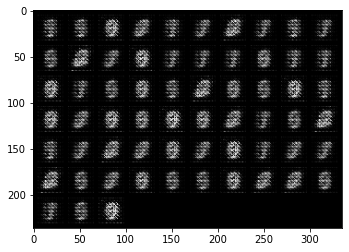

outputs:  torch.Size([10, 10])
	 tensor([[ 0.0000,  0.0000,  0.0000, 19.6697,  0.0000,  3.6337,  0.0000,  3.0324,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  2.7888,  1.4257,  0.0000,  4.7840,  0.0000,  1.2507,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.1464,  0.0000,  0.0000,  2.7837,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.6380,  0.0000,  0.0000,  0.0000,  0.4845,  0.0000,
          0.0000,  0.8843],
        [ 0.0000, 13.4068,  0.0000, 15.6737,  0.0000,  2.5833,  0.0000,  6.8195,
          0.0000,  0.0000],
        [ 7.6625,  0.0000,  7.2929,  0.0000,  0.0000,  0.0000,  3.0530,  0.0000,
         19.4057,  0.0000],
        [ 0.2616,  0.0000,  0.0000,  0.0000,  5.8321,  0.0000,  0.0000,  1.5175,
          0.0000,  7.1862],
        [ 3.0374,  0.0000,  0.0000,  0.4069,  0.0000,  0.0000,  0.0000,  0.0000,
         12.8856,  0.0000],
        [ 0.2792,  0.0000,  0.0000,  0.0000,  5.7368,  0.0000,  0.0000,  1.4282,
          0.00

<Figure size 72x720 with 0 Axes>

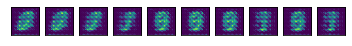

Epoch: [ 2] [  50/ 200] D_loss: 4.75737190, G_loss: 0.00722343
Epoch: [ 2] [ 100/ 200] D_loss: 11.09153843, G_loss: 0.05529982
Epoch: [ 2] [ 150/ 200] D_loss: 4.56413651, G_loss: 0.00321633
Epoch: [ 2] [ 200/ 200] D_loss: 5.07094193, G_loss: 0.00674683


<Figure size 72x720 with 0 Axes>

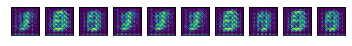

Epoch: [ 3] [  50/ 200] D_loss: 3.28392458, G_loss: 0.00624567
Epoch: [ 3] [ 100/ 200] D_loss: 5.15972471, G_loss: 0.00274414
Epoch: [ 3] [ 150/ 200] D_loss: 5.39045429, G_loss: 0.00220376
Epoch: [ 3] [ 200/ 200] D_loss: 4.14113808, G_loss: 0.01773787


<Figure size 72x720 with 0 Axes>

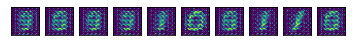

Epoch: [ 4] [  50/ 200] D_loss: 5.47038603, G_loss: 0.00358653
Epoch: [ 4] [ 100/ 200] D_loss: 3.00598812, G_loss: 0.00862300
Epoch: [ 4] [ 150/ 200] D_loss: 5.84838057, G_loss: 0.01625293
Epoch: [ 4] [ 200/ 200] D_loss: 4.67400169, G_loss: 0.00856835


<Figure size 72x720 with 0 Axes>

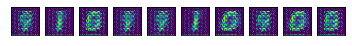

Epoch: [ 5] [  50/ 200] D_loss: 7.72876501, G_loss: 0.00025398
Epoch: [ 5] [ 100/ 200] D_loss: 5.47038937, G_loss: 0.01258636
Epoch: [ 5] [ 150/ 200] D_loss: 5.78437853, G_loss: 0.00268066
Epoch: [ 5] [ 200/ 200] D_loss: 4.26680660, G_loss: 0.00993013


<Figure size 72x720 with 0 Axes>

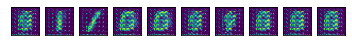

Epoch: [ 6] [  50/ 200] D_loss: 5.24852943, G_loss: 0.00599837
Epoch: [ 6] [ 100/ 200] D_loss: 5.67031193, G_loss: 0.02372545
Epoch: [ 6] [ 150/ 200] D_loss: 4.70403290, G_loss: 0.02152413
Epoch: [ 6] [ 200/ 200] D_loss: 4.27777195, G_loss: 0.01450431


<Figure size 72x720 with 0 Axes>

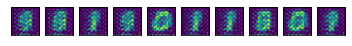

Epoch: [ 7] [  50/ 200] D_loss: 5.21171379, G_loss: 0.03450692
Epoch: [ 7] [ 100/ 200] D_loss: 4.33009434, G_loss: 0.01964152
Epoch: [ 7] [ 150/ 200] D_loss: 5.06249571, G_loss: 0.06825823
Epoch: [ 7] [ 200/ 200] D_loss: 4.97037792, G_loss: 0.05004346


<Figure size 72x720 with 0 Axes>

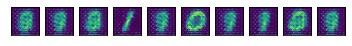

Epoch: [ 8] [  50/ 200] D_loss: 4.60635519, G_loss: 0.03854197
Epoch: [ 8] [ 100/ 200] D_loss: 3.31575751, G_loss: 0.04493785
Epoch: [ 8] [ 150/ 200] D_loss: 4.85905170, G_loss: 0.06609535
Epoch: [ 8] [ 200/ 200] D_loss: 4.71562672, G_loss: 0.09959960


<Figure size 72x720 with 0 Axes>

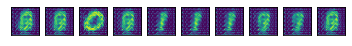

Epoch: [ 9] [  50/ 200] D_loss: 4.17426443, G_loss: 0.09945053
Epoch: [ 9] [ 100/ 200] D_loss: 5.18547010, G_loss: 0.09880000
Epoch: [ 9] [ 150/ 200] D_loss: 5.87788010, G_loss: 0.12820268
Epoch: [ 9] [ 200/ 200] D_loss: 4.09820557, G_loss: 0.14208901


<Figure size 72x720 with 0 Axes>

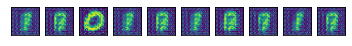

Epoch: [10] [  50/ 200] D_loss: 3.39249063, G_loss: 0.14973193
Epoch: [10] [ 100/ 200] D_loss: 5.56755447, G_loss: 0.15295112
Epoch: [10] [ 150/ 200] D_loss: 2.13454032, G_loss: 0.17166358
Epoch: [10] [ 200/ 200] D_loss: 5.11008406, G_loss: 0.14906549


<Figure size 72x720 with 0 Axes>

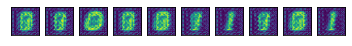

Epoch: [11] [  50/ 200] D_loss: 4.74934959, G_loss: 0.11022526
Epoch: [11] [ 100/ 200] D_loss: 4.69349337, G_loss: 0.19115639
Epoch: [11] [ 150/ 200] D_loss: 4.10227966, G_loss: 0.22309673
Epoch: [11] [ 200/ 200] D_loss: 4.55632257, G_loss: 0.20324987
Training at Epoch:
10


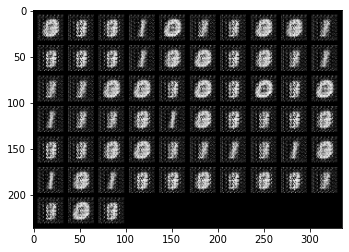

outputs:  torch.Size([10, 10])
	 tensor([[ 2.3349,  0.0000,  6.1769,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          7.6930,  1.2476],
        [ 0.0000, 29.9921,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  9.0619,
          0.0000,  0.0000],
        [ 4.4995,  0.0000,  6.4464,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          6.5085,  2.5175],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  8.6897,  0.0000,  0.0000,  0.0000,
         10.3854,  2.1444],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  7.8970,  0.0000,  0.0000,  0.0000,
          8.6861,  4.7433],
        [ 0.0000,  0.0000,  0.0000,  1.0155,  4.0823,  7.3346,  0.0000,  0.0000,
          2.9787,  5.2883],
        [ 0.0000,  0.0000,  0.0000,  8.0025,  2.0074,  8.8843,  0.0000,  0.0000,
          0.0000,  5.9675],
        [ 0.0000, 16.6047,  0.0000,  7.9194,  0.0000,  0.0000,  0.0000,  7.0862,
          0.0000,  0.0000],
        [ 0.0000, 19.6384,  0.0000,  5.3052,  0.0000,  0.0000,  0.0000,  7.6503,
          0.00

<Figure size 72x720 with 0 Axes>

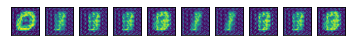

Epoch: [12] [  50/ 200] D_loss: 3.32720804, G_loss: 0.21527398
Epoch: [12] [ 100/ 200] D_loss: 2.85229445, G_loss: 0.21395701
Epoch: [12] [ 150/ 200] D_loss: 1.92630696, G_loss: 0.30600291
Epoch: [12] [ 200/ 200] D_loss: 2.03833938, G_loss: 0.23067331


<Figure size 72x720 with 0 Axes>

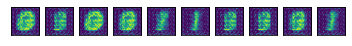

Epoch: [13] [  50/ 200] D_loss: 1.57215333, G_loss: 0.22119868
Epoch: [13] [ 100/ 200] D_loss: 1.79371977, G_loss: 0.37481093
Epoch: [13] [ 150/ 200] D_loss: 7.82061577, G_loss: 0.35684013
Epoch: [13] [ 200/ 200] D_loss: 2.16933036, G_loss: 0.42478016


<Figure size 72x720 with 0 Axes>

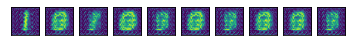

Epoch: [14] [  50/ 200] D_loss: 5.27439165, G_loss: 0.32453743
Epoch: [14] [ 100/ 200] D_loss: 3.59514403, G_loss: 0.36098373
Epoch: [14] [ 150/ 200] D_loss: 2.18692875, G_loss: 0.38079578
Epoch: [14] [ 200/ 200] D_loss: 2.67526460, G_loss: 0.28820732


<Figure size 72x720 with 0 Axes>

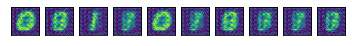

Epoch: [15] [  50/ 200] D_loss: 4.06982708, G_loss: 0.34819168
Epoch: [15] [ 100/ 200] D_loss: 1.59512150, G_loss: 0.41062695
Epoch: [15] [ 150/ 200] D_loss: 2.38144493, G_loss: 0.48664999
Epoch: [15] [ 200/ 200] D_loss: 1.08279121, G_loss: 0.47321817


<Figure size 72x720 with 0 Axes>

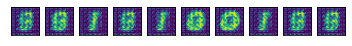

Epoch: [16] [  50/ 200] D_loss: 1.33015752, G_loss: 0.52637553
Epoch: [16] [ 100/ 200] D_loss: 1.13946319, G_loss: 0.51164979
Epoch: [16] [ 150/ 200] D_loss: 1.66493809, G_loss: 0.57513297
Epoch: [16] [ 200/ 200] D_loss: 1.58706331, G_loss: 0.48886892


<Figure size 72x720 with 0 Axes>

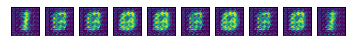

Epoch: [17] [  50/ 200] D_loss: 1.48038626, G_loss: 0.56904578
Epoch: [17] [ 100/ 200] D_loss: 1.17719889, G_loss: 0.44678599
Epoch: [17] [ 150/ 200] D_loss: 1.16954613, G_loss: 0.60579193
Epoch: [17] [ 200/ 200] D_loss: 1.27014685, G_loss: 0.64099234


<Figure size 72x720 with 0 Axes>

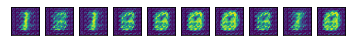

Epoch: [18] [  50/ 200] D_loss: 1.69116426, G_loss: 0.43857345
Epoch: [18] [ 100/ 200] D_loss: 2.89286661, G_loss: 0.64124858
Epoch: [18] [ 150/ 200] D_loss: 2.56712866, G_loss: 0.54386336
Epoch: [18] [ 200/ 200] D_loss: 6.75318670, G_loss: 0.56199992


<Figure size 72x720 with 0 Axes>

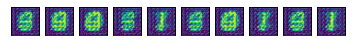

Epoch: [19] [  50/ 200] D_loss: 1.60142303, G_loss: 0.48144042
Epoch: [19] [ 100/ 200] D_loss: 1.53753388, G_loss: 0.61706907
Epoch: [19] [ 150/ 200] D_loss: 2.64285469, G_loss: 0.47872764
Epoch: [19] [ 200/ 200] D_loss: 1.20944238, G_loss: 0.65679294


<Figure size 72x720 with 0 Axes>

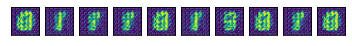

Epoch: [20] [  50/ 200] D_loss: 2.28883886, G_loss: 0.62796336
Epoch: [20] [ 100/ 200] D_loss: 1.24129915, G_loss: 0.61470103
Epoch: [20] [ 150/ 200] D_loss: 2.30968761, G_loss: 0.38795054
Epoch: [20] [ 200/ 200] D_loss: 2.01391006, G_loss: 0.63221228


<Figure size 72x720 with 0 Axes>

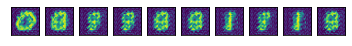

Epoch: [21] [  50/ 200] D_loss: 1.33618677, G_loss: 0.69608647
Epoch: [21] [ 100/ 200] D_loss: 1.32033610, G_loss: 0.56649041
Epoch: [21] [ 150/ 200] D_loss: 1.17986894, G_loss: 0.60624272
Epoch: [21] [ 200/ 200] D_loss: 2.32270670, G_loss: 0.56752491
Training at Epoch:
20


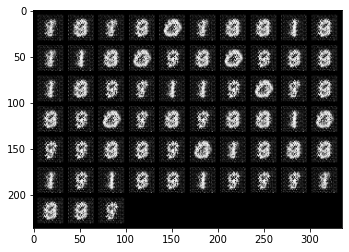

outputs:  torch.Size([10, 10])
	 tensor([[ 0.0000,  0.0000,  0.0000,  6.9879,  0.0000,  0.0000,  0.0000,  2.7370,
          1.8187,  0.0567],
        [38.6942,  0.0000,  1.1379,  0.0000,  0.0000,  0.0000,  6.8408,  0.0000,
          0.0000,  0.0000],
        [ 0.0000, 40.6457,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  6.2513,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  7.3227,  0.0000,  0.0000,  0.0000,  1.5642,
          0.0000,  0.0559],
        [ 0.0000,  0.0000,  0.2719,  4.3836,  0.0000,  2.6576,  0.0000,  0.0000,
          0.6099,  1.0092],
        [ 0.0000,  0.0000,  3.3618,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          5.2675,  3.0560],
        [ 0.2234,  0.0000,  3.9420,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          5.7329,  2.7492],
        [ 0.0000,  0.0000,  0.0000,  7.5122,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  3.6927,  0.0000,  0.0000,  0.0000,  0.0000,
         10.64

<Figure size 72x720 with 0 Axes>

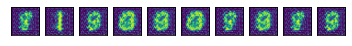

Epoch: [22] [  50/ 200] D_loss: 1.01495719, G_loss: 0.63467711
Epoch: [22] [ 100/ 200] D_loss: 1.28967834, G_loss: 0.62390226
Epoch: [22] [ 150/ 200] D_loss: 1.37142980, G_loss: 0.65223533
Epoch: [22] [ 200/ 200] D_loss: 2.26129818, G_loss: 0.49233225


<Figure size 72x720 with 0 Axes>

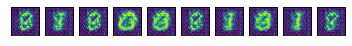

Epoch: [23] [  50/ 200] D_loss: 1.14558697, G_loss: 0.68860209
Epoch: [23] [ 100/ 200] D_loss: 1.16107798, G_loss: 0.65617430
Epoch: [23] [ 150/ 200] D_loss: 1.70328736, G_loss: 0.62088645
Epoch: [23] [ 200/ 200] D_loss: 1.16080236, G_loss: 0.63600320


<Figure size 72x720 with 0 Axes>

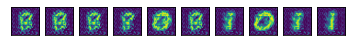

Epoch: [24] [  50/ 200] D_loss: 1.32336986, G_loss: 0.70559299
Epoch: [24] [ 100/ 200] D_loss: 4.01507807, G_loss: 0.74949449
Epoch: [24] [ 150/ 200] D_loss: 1.16410780, G_loss: 0.65893137
Epoch: [24] [ 200/ 200] D_loss: 1.09527779, G_loss: 0.77677733


<Figure size 72x720 with 0 Axes>

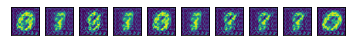

Epoch: [25] [  50/ 200] D_loss: 1.41306186, G_loss: 0.70378584
Epoch: [25] [ 100/ 200] D_loss: 3.64109230, G_loss: 0.67858547
Epoch: [25] [ 150/ 200] D_loss: 1.07748318, G_loss: 0.71697348
Epoch: [25] [ 200/ 200] D_loss: 1.20503426, G_loss: 0.81190187


<Figure size 72x720 with 0 Axes>

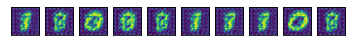

Epoch: [26] [  50/ 200] D_loss: 2.19392109, G_loss: 0.69828296
Epoch: [26] [ 100/ 200] D_loss: 4.96369934, G_loss: 0.66945428
Epoch: [26] [ 150/ 200] D_loss: 1.18195713, G_loss: 0.55227357
Epoch: [26] [ 200/ 200] D_loss: 2.14560795, G_loss: 0.72695506


<Figure size 72x720 with 0 Axes>

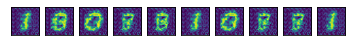

Epoch: [27] [  50/ 200] D_loss: 1.47287607, G_loss: 0.72763616
Epoch: [27] [ 100/ 200] D_loss: 2.39341974, G_loss: 0.66144466
Epoch: [27] [ 150/ 200] D_loss: 1.39757240, G_loss: 0.77030730
Epoch: [27] [ 200/ 200] D_loss: 6.90259457, G_loss: 0.68826383


<Figure size 72x720 with 0 Axes>

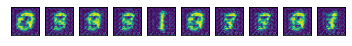

Epoch: [28] [  50/ 200] D_loss: 1.16205680, G_loss: 0.65737754
Epoch: [28] [ 100/ 200] D_loss: 1.26587594, G_loss: 0.77928442
Epoch: [28] [ 150/ 200] D_loss: 3.20151615, G_loss: 0.76697707
Epoch: [28] [ 200/ 200] D_loss: 1.79062915, G_loss: 0.58260196


<Figure size 72x720 with 0 Axes>

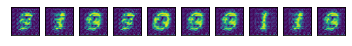

Epoch: [29] [  50/ 200] D_loss: 1.11379755, G_loss: 0.68243480
Epoch: [29] [ 100/ 200] D_loss: 6.55385494, G_loss: 0.56077135
Epoch: [29] [ 150/ 200] D_loss: 1.12895799, G_loss: 0.56762183
Epoch: [29] [ 200/ 200] D_loss: 1.33443260, G_loss: 0.80327553


<Figure size 72x720 with 0 Axes>

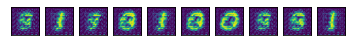

Epoch: [30] [  50/ 200] D_loss: 1.13857555, G_loss: 0.78981727
Epoch: [30] [ 100/ 200] D_loss: 1.47362030, G_loss: 0.77299362
Epoch: [30] [ 150/ 200] D_loss: 1.33474302, G_loss: 0.71430779
Epoch: [30] [ 200/ 200] D_loss: 2.45203924, G_loss: 0.56458509


<Figure size 72x720 with 0 Axes>

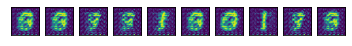

Epoch: [31] [  50/ 200] D_loss: 1.16215694, G_loss: 0.71391660
Epoch: [31] [ 100/ 200] D_loss: 1.70278168, G_loss: 0.62024724
Epoch: [31] [ 150/ 200] D_loss: 7.82676792, G_loss: 0.68271464
Epoch: [31] [ 200/ 200] D_loss: 1.10283256, G_loss: 0.79339802
Training at Epoch:
30


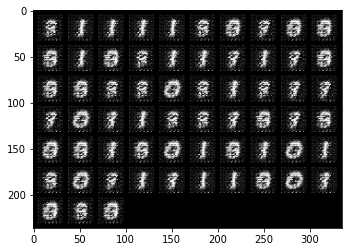

outputs:  torch.Size([10, 10])
	 tensor([[ 0.0000, 11.7136,  0.0000,  3.7543,  4.6284,  0.0000,  0.0000,  4.3450,
          5.2305,  0.0000],
        [ 0.0000,  0.0000,  5.6753,  0.0000,  0.0000,  0.0000,  0.6775,  0.0000,
          4.5173,  1.1136],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  7.3052,  0.0000,  0.0000,
         13.5257,  0.9593],
        [ 0.0000,  0.0000,  4.1496,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         11.0038,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.1842,  0.0000,  0.0000,  0.0000,  4.5260,
          0.0000,  5.4739],
        [ 0.0000, 41.5948,  0.0000,  0.0000,  8.9535,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.4303,  0.0000,  0.0000,  0.0000,  1.8394,
          0.0000,  6.0136],
        [ 0.0000,  0.0000,  0.0000,  0.0857,  0.0000,  0.0000,  0.0000,  5.8441,
          0.0000,  4.8798],
        [ 0.0000,  0.1641,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  7.7929,
          0.09

<Figure size 72x720 with 0 Axes>

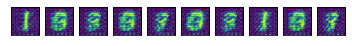

Epoch: [32] [  50/ 200] D_loss: 1.26638472, G_loss: 0.82775986
Epoch: [32] [ 100/ 200] D_loss: 1.45008683, G_loss: 0.77221411
Epoch: [32] [ 150/ 200] D_loss: 3.07210827, G_loss: 0.80481488
Epoch: [32] [ 200/ 200] D_loss: 2.08172870, G_loss: 0.79807001


<Figure size 72x720 with 0 Axes>

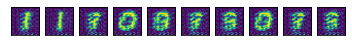

Epoch: [33] [  50/ 200] D_loss: 33.63888550, G_loss: 0.79502726
Epoch: [33] [ 100/ 200] D_loss: 1.67627299, G_loss: 0.80685323
Epoch: [33] [ 150/ 200] D_loss: 1.30217671, G_loss: 0.72496068
Epoch: [33] [ 200/ 200] D_loss: 1.28058004, G_loss: 0.80417538


<Figure size 72x720 with 0 Axes>

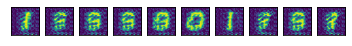

Epoch: [34] [  50/ 200] D_loss: 3.35844135, G_loss: 0.73925984
Epoch: [34] [ 100/ 200] D_loss: 0.92131335, G_loss: 0.79177618
Epoch: [34] [ 150/ 200] D_loss: 1.61416936, G_loss: 0.78018129
Epoch: [34] [ 200/ 200] D_loss: 1.43852019, G_loss: 0.72225368


<Figure size 72x720 with 0 Axes>

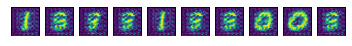

Epoch: [35] [  50/ 200] D_loss: 1.40976453, G_loss: 0.76123130
Epoch: [35] [ 100/ 200] D_loss: 1.75684261, G_loss: 0.68643153
Epoch: [35] [ 150/ 200] D_loss: 1.28552866, G_loss: 0.67834091
Epoch: [35] [ 200/ 200] D_loss: 2.86588955, G_loss: 0.81543374


<Figure size 72x720 with 0 Axes>

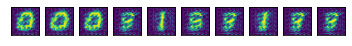

Epoch: [36] [  50/ 200] D_loss: 1.16125882, G_loss: 0.80317473
Epoch: [36] [ 100/ 200] D_loss: 0.97215390, G_loss: 0.67982095
Epoch: [36] [ 150/ 200] D_loss: 0.92541230, G_loss: 0.67644370
Epoch: [36] [ 200/ 200] D_loss: 1.69244599, G_loss: 0.69697553


<Figure size 72x720 with 0 Axes>

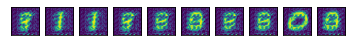

Epoch: [37] [  50/ 200] D_loss: 1.13438356, G_loss: 0.76880872
Epoch: [37] [ 100/ 200] D_loss: 1.89450121, G_loss: 0.82591361
Epoch: [37] [ 150/ 200] D_loss: 1.50243163, G_loss: 0.84492105
Epoch: [37] [ 200/ 200] D_loss: 1.85865796, G_loss: 0.78367335


<Figure size 72x720 with 0 Axes>

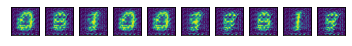

Epoch: [38] [  50/ 200] D_loss: 1.70561647, G_loss: 0.72497702
Epoch: [38] [ 100/ 200] D_loss: 2.03131080, G_loss: 0.79447234
Epoch: [38] [ 150/ 200] D_loss: 2.05414271, G_loss: 0.82151312
Epoch: [38] [ 200/ 200] D_loss: 1.04325533, G_loss: 0.71432698


<Figure size 72x720 with 0 Axes>

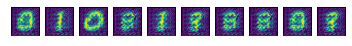

Epoch: [39] [  50/ 200] D_loss: 1.11775470, G_loss: 0.79077524
Epoch: [39] [ 100/ 200] D_loss: 1.17812741, G_loss: 0.83445942
Epoch: [39] [ 150/ 200] D_loss: 0.93457925, G_loss: 0.74135637
Epoch: [39] [ 200/ 200] D_loss: 1.17961490, G_loss: 0.89481807


<Figure size 72x720 with 0 Axes>

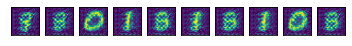

Epoch: [40] [  50/ 200] D_loss: 2.03467155, G_loss: 0.79302877
Epoch: [40] [ 100/ 200] D_loss: 1.77637315, G_loss: 0.80272782
Epoch: [40] [ 150/ 200] D_loss: 1.69535470, G_loss: 0.77390355
Epoch: [40] [ 200/ 200] D_loss: 1.30897033, G_loss: 0.77719682


<Figure size 72x720 with 0 Axes>

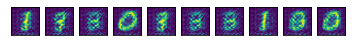

Epoch: [41] [  50/ 200] D_loss: 0.97871578, G_loss: 0.63212478
Epoch: [41] [ 100/ 200] D_loss: 1.85809755, G_loss: 0.80695462
Epoch: [41] [ 150/ 200] D_loss: 1.16689539, G_loss: 0.81516200
Epoch: [41] [ 200/ 200] D_loss: 1.08701444, G_loss: 0.73032069
Training at Epoch:
40


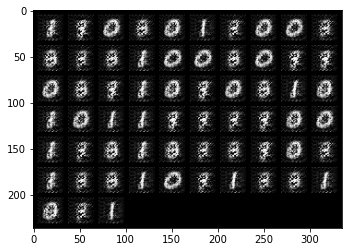

outputs:  torch.Size([10, 10])
	 tensor([[ 0.0000,  0.0000,  1.7170, 14.8073,  0.0000,  0.0000,  0.0000,  0.0000,
          4.4698,  1.7497],
        [ 0.0000,  0.0000,  0.0000,  6.8529,  0.0000,  0.0000,  0.0000,  2.0097,
          9.0886,  5.5724],
        [ 0.0000, 22.6867,  0.0000,  0.0000,  0.1795,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000, 15.8590,  0.0000,  0.0000,  0.0000,  0.0000,  0.3759,  0.0000,
          0.0000,  0.0000],
        [ 0.0000, 27.6396,  0.0000,  0.0000,  0.5715,  0.0000,  0.0000,  0.1725,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  5.7236,  9.5140,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [16.0708,  0.0000,  6.6993,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          6.3368, 14.0687],
        [ 0.0000,  0.0000,  0.0000,  2.9164,  0.7701,  0.0000,  0.0000,  4.0475,
          1.7982,  6.8376],
        [33.7969,  0.0000,  1.7439,  0.0000,  0.0000,  0.0000,  0.4407,  0.0000,
          0.00

<Figure size 72x720 with 0 Axes>

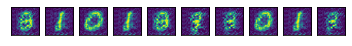

Epoch: [42] [  50/ 200] D_loss: 4.93957329, G_loss: 0.80573332
Epoch: [42] [ 100/ 200] D_loss: 1.16300547, G_loss: 0.83572060
Epoch: [42] [ 150/ 200] D_loss: 1.32943106, G_loss: 0.87466502
Epoch: [42] [ 200/ 200] D_loss: 4.91014814, G_loss: 0.71115446


<Figure size 72x720 with 0 Axes>

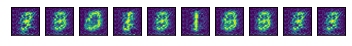

Epoch: [43] [  50/ 200] D_loss: 1.71634293, G_loss: 0.77814615
Epoch: [43] [ 100/ 200] D_loss: 1.63559484, G_loss: 0.70685434
Epoch: [43] [ 150/ 200] D_loss: 4.47401762, G_loss: 0.76000369
Epoch: [43] [ 200/ 200] D_loss: 1.08267045, G_loss: 0.78692794


<Figure size 72x720 with 0 Axes>

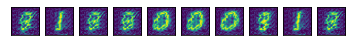

Epoch: [44] [  50/ 200] D_loss: 1.19922888, G_loss: 0.79909766
Epoch: [44] [ 100/ 200] D_loss: 1.50498402, G_loss: 0.81141609
Epoch: [44] [ 150/ 200] D_loss: 1.26605880, G_loss: 0.83343482
Epoch: [44] [ 200/ 200] D_loss: 1.64046609, G_loss: 0.83158338


<Figure size 72x720 with 0 Axes>

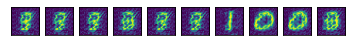

Epoch: [45] [  50/ 200] D_loss: 1.34587252, G_loss: 0.75385237
Epoch: [45] [ 100/ 200] D_loss: 6.32515144, G_loss: 0.69194758
Epoch: [45] [ 150/ 200] D_loss: 3.22611570, G_loss: 0.76971269
Epoch: [45] [ 200/ 200] D_loss: 1.52409267, G_loss: 0.88870376


<Figure size 72x720 with 0 Axes>

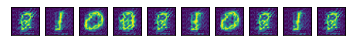

Epoch: [46] [  50/ 200] D_loss: 1.88019109, G_loss: 0.91250634
Epoch: [46] [ 100/ 200] D_loss: 1.48421979, G_loss: 0.89297080
Epoch: [46] [ 150/ 200] D_loss: 2.93711972, G_loss: 0.57908714
Epoch: [46] [ 200/ 200] D_loss: 1.45162320, G_loss: 0.74787962


<Figure size 72x720 with 0 Axes>

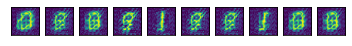

Epoch: [47] [  50/ 200] D_loss: 1.83258045, G_loss: 0.88180274
Epoch: [47] [ 100/ 200] D_loss: 1.51835215, G_loss: 0.87557667
Epoch: [47] [ 150/ 200] D_loss: 9.51434040, G_loss: 0.78804255
Epoch: [47] [ 200/ 200] D_loss: 1.85358131, G_loss: 0.87351334


<Figure size 72x720 with 0 Axes>

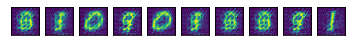

Epoch: [48] [  50/ 200] D_loss: 1.58912551, G_loss: 0.81889522
Epoch: [48] [ 100/ 200] D_loss: 1.17744040, G_loss: 0.73580706
Epoch: [48] [ 150/ 200] D_loss: 1.70258951, G_loss: 0.92464018
Epoch: [48] [ 200/ 200] D_loss: 1.35835874, G_loss: 0.72784340


<Figure size 72x720 with 0 Axes>

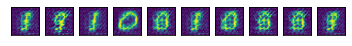

Epoch: [49] [  50/ 200] D_loss: 1.35871136, G_loss: 0.75733697
Epoch: [49] [ 100/ 200] D_loss: 1.20257282, G_loss: 0.78398424
Epoch: [49] [ 150/ 200] D_loss: 1.54783976, G_loss: 0.72637296
Epoch: [49] [ 200/ 200] D_loss: 1.22924113, G_loss: 0.90033102


<Figure size 72x720 with 0 Axes>

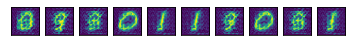

Epoch: [50] [  50/ 200] D_loss: 1.30437207, G_loss: 0.91014659
Epoch: [50] [ 100/ 200] D_loss: 1.79349577, G_loss: 0.79213166
Epoch: [50] [ 150/ 200] D_loss: 1.37927771, G_loss: 0.84566534
Epoch: [50] [ 200/ 200] D_loss: 1.34186935, G_loss: 0.91550195


<Figure size 72x720 with 0 Axes>

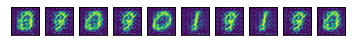

Epoch: [51] [  50/ 200] D_loss: 9.59297466, G_loss: 0.84585816
Epoch: [51] [ 100/ 200] D_loss: 1.05468524, G_loss: 0.77761328
Epoch: [51] [ 150/ 200] D_loss: 2.64949799, G_loss: 0.86596680
Epoch: [51] [ 200/ 200] D_loss: 1.55347848, G_loss: 0.81855720
Training at Epoch:
50


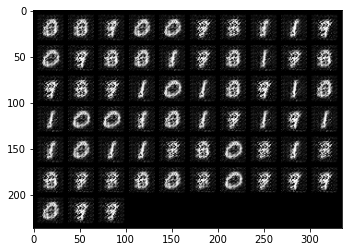

outputs:  torch.Size([10, 10])
	 tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0110e+00, 0.0000e+00,
         0.0000e+00, 9.7194e-01, 0.0000e+00, 1.3270e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.9492e+00, 0.0000e+00,
         0.0000e+00, 7.0441e-01, 0.0000e+00, 1.7548e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 3.3572e-01, 2.7359e+00, 5.4897e+00,
         0.0000e+00, 6.3941e+00, 4.8519e-01, 1.5422e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 7.0347e+00, 4.2215e+00, 4.5693e+00],
        [0.0000e+00, 0.0000e+00, 7.3737e-01, 1.2724e+01, 0.0000e+00, 4.8943e+00,
         0.0000e+00, 0.0000e+00, 1.4507e+01, 1.6747e+00],
        [0.0000e+00, 4.8623e-01, 0.0000e+00, 0.0000e+00, 4.9820e-03, 0.0000e+00,
         0.0000e+00, 9.9862e-01, 0.0000e+00, 7.2765e+00],
        [1.1643e+00, 3.7081e+01, 1.7329e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         4.4433e-01, 3.5198e+00, 0.0000e+00, 0.0000e

<Figure size 72x720 with 0 Axes>

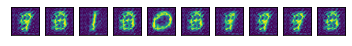

Epoch: [52] [  50/ 200] D_loss: 1.56600952, G_loss: 0.85340834
Epoch: [52] [ 100/ 200] D_loss: 1.94031000, G_loss: 0.89007157
Epoch: [52] [ 150/ 200] D_loss: 1.96973562, G_loss: 0.87043315
Epoch: [52] [ 200/ 200] D_loss: 1.26088536, G_loss: 0.87905854


<Figure size 72x720 with 0 Axes>

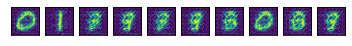

Epoch: [53] [  50/ 200] D_loss: 1.85551631, G_loss: 0.67745090
Epoch: [53] [ 100/ 200] D_loss: 1.80139983, G_loss: 0.90882540
Epoch: [53] [ 150/ 200] D_loss: 1.50426042, G_loss: 0.81098062
Epoch: [53] [ 200/ 200] D_loss: 1.81212842, G_loss: 0.88109219


<Figure size 72x720 with 0 Axes>

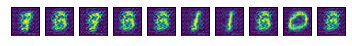

Epoch: [54] [  50/ 200] D_loss: 1.29144192, G_loss: 0.80643547
Epoch: [54] [ 100/ 200] D_loss: 1.35614252, G_loss: 0.93352747
Epoch: [54] [ 150/ 200] D_loss: 2.65623093, G_loss: 0.85366130
Epoch: [54] [ 200/ 200] D_loss: 1.77487147, G_loss: 0.73522288


<Figure size 72x720 with 0 Axes>

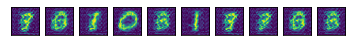

Epoch: [55] [  50/ 200] D_loss: 5.59856701, G_loss: 0.94674927
Epoch: [55] [ 100/ 200] D_loss: 1.35403657, G_loss: 0.89955735
Epoch: [55] [ 150/ 200] D_loss: 3.73050928, G_loss: 0.84882897
Epoch: [55] [ 200/ 200] D_loss: 1.36618042, G_loss: 0.91687733


<Figure size 72x720 with 0 Axes>

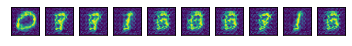

Epoch: [56] [  50/ 200] D_loss: 3.06616092, G_loss: 0.74987841
Epoch: [56] [ 100/ 200] D_loss: 1.64322948, G_loss: 0.84708202
Epoch: [56] [ 150/ 200] D_loss: 6.17100000, G_loss: 0.85550553
Epoch: [56] [ 200/ 200] D_loss: 1.96301281, G_loss: 0.54064786


<Figure size 72x720 with 0 Axes>

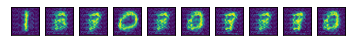

Epoch: [57] [  50/ 200] D_loss: 1.64529371, G_loss: 0.92263347
Epoch: [57] [ 100/ 200] D_loss: 2.57420182, G_loss: 0.81646574
Epoch: [57] [ 150/ 200] D_loss: 1.72010112, G_loss: 0.92796063
Epoch: [57] [ 200/ 200] D_loss: 1.57529020, G_loss: 0.81439137


<Figure size 72x720 with 0 Axes>

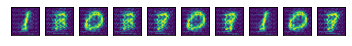

Epoch: [58] [  50/ 200] D_loss: 2.56605530, G_loss: 0.82721674
Epoch: [58] [ 100/ 200] D_loss: 2.14880633, G_loss: 0.83964944
Epoch: [58] [ 150/ 200] D_loss: 2.54359722, G_loss: 0.84926307
Epoch: [58] [ 200/ 200] D_loss: 1.25430882, G_loss: 0.88165843


<Figure size 72x720 with 0 Axes>

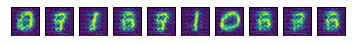

Epoch: [59] [  50/ 200] D_loss: 2.92511940, G_loss: 0.83704329
Epoch: [59] [ 100/ 200] D_loss: 1.55809343, G_loss: 0.81218588
Epoch: [59] [ 150/ 200] D_loss: 1.78621030, G_loss: 0.89740789
Epoch: [59] [ 200/ 200] D_loss: 2.22824383, G_loss: 0.73870933


<Figure size 72x720 with 0 Axes>

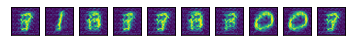

Epoch: [60] [  50/ 200] D_loss: 2.53816390, G_loss: 0.84458780
Epoch: [60] [ 100/ 200] D_loss: 2.11178088, G_loss: 0.84946287
Epoch: [60] [ 150/ 200] D_loss: 1.70890868, G_loss: 0.74443299
Epoch: [60] [ 200/ 200] D_loss: 2.41602421, G_loss: 0.84920204


<Figure size 72x720 with 0 Axes>

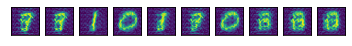

Epoch: [61] [  50/ 200] D_loss: 2.63205671, G_loss: 0.84749603
Epoch: [61] [ 100/ 200] D_loss: 1.81467772, G_loss: 0.88567328
Epoch: [61] [ 150/ 200] D_loss: 3.27028704, G_loss: 0.70383513
Epoch: [61] [ 200/ 200] D_loss: 2.44253445, G_loss: 0.85590768
Training at Epoch:
60


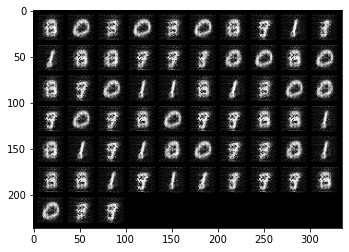

outputs:  torch.Size([10, 10])
	 tensor([[ 0.0000,  0.0000,  0.0000,  0.1655,  0.2972,  0.0000,  0.0000,  5.8584,
          3.7523,  8.1011],
        [ 0.0000,  0.0000,  0.0000,  2.8594,  0.0000,  1.7034,  0.0000,  2.9871,
          3.9954, 11.5000],
        [ 0.0000, 39.7239,  7.1024,  0.0000,  0.0000,  0.0000,  0.0000,  3.3809,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.2396,  0.2488,  0.0000,  0.0000,  5.7946,
          3.7428,  8.1495],
        [ 0.0000,  0.0000,  5.1200,  8.0220,  0.0000,  0.0000,  5.5952,  0.0000,
          7.7982,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.7833,  0.0000,  0.0000,  6.1682,
          3.8208,  7.2334],
        [ 0.0000,  0.0000,  3.4099,  8.1495,  0.0000,  0.0000,  5.6713,  0.0000,
          7.7592,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  7.2525,  0.0000,  0.0000,  0.0000,  4.3028,
          1.8777,  0.0000],
        [14.0682,  0.0000,  9.9670,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.00

<Figure size 72x720 with 0 Axes>

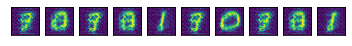

Epoch: [62] [  50/ 200] D_loss: 1.92649555, G_loss: 0.91328526
Epoch: [62] [ 100/ 200] D_loss: 2.11187649, G_loss: 0.81739819
Epoch: [62] [ 150/ 200] D_loss: 1.76795876, G_loss: 0.87021482
Epoch: [62] [ 200/ 200] D_loss: 2.12016821, G_loss: 0.83376098


<Figure size 72x720 with 0 Axes>

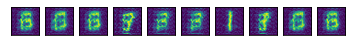

Epoch: [63] [  50/ 200] D_loss: 1.86780465, G_loss: 0.83607459
Epoch: [63] [ 100/ 200] D_loss: 2.02484989, G_loss: 0.92445236
Epoch: [63] [ 150/ 200] D_loss: 2.03448510, G_loss: 0.85273367
Epoch: [63] [ 200/ 200] D_loss: 1.87634540, G_loss: 0.90005988


<Figure size 72x720 with 0 Axes>

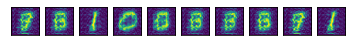

Epoch: [64] [  50/ 200] D_loss: 1.90247369, G_loss: 0.83313793
Epoch: [64] [ 100/ 200] D_loss: 1.82685900, G_loss: 0.82315397
Epoch: [64] [ 150/ 200] D_loss: 4.66627979, G_loss: 0.84239256
Epoch: [64] [ 200/ 200] D_loss: 1.62428808, G_loss: 0.83872867


<Figure size 72x720 with 0 Axes>

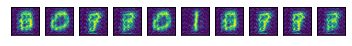

Epoch: [65] [  50/ 200] D_loss: 2.35890651, G_loss: 0.91509604
Epoch: [65] [ 100/ 200] D_loss: 2.71689034, G_loss: 0.81262362
Epoch: [65] [ 150/ 200] D_loss: 1.78854156, G_loss: 0.89885426
Epoch: [65] [ 200/ 200] D_loss: 2.11526155, G_loss: 0.84940386


<Figure size 72x720 with 0 Axes>

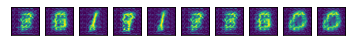

Epoch: [66] [  50/ 200] D_loss: 8.70937824, G_loss: 0.78117830
Epoch: [66] [ 100/ 200] D_loss: 1.41738737, G_loss: 0.85415405
Epoch: [66] [ 150/ 200] D_loss: 1.30658495, G_loss: 0.90914530
Epoch: [66] [ 200/ 200] D_loss: 1.76631999, G_loss: 0.87278318


<Figure size 72x720 with 0 Axes>

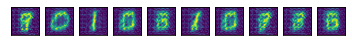

Epoch: [67] [  50/ 200] D_loss: 1.47345531, G_loss: 0.96112859
Epoch: [67] [ 100/ 200] D_loss: 2.04355884, G_loss: 0.89171797
Epoch: [67] [ 150/ 200] D_loss: 1.81496453, G_loss: 0.73708504
Epoch: [67] [ 200/ 200] D_loss: 1.46874273, G_loss: 0.90524155


<Figure size 72x720 with 0 Axes>

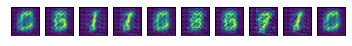

Epoch: [68] [  50/ 200] D_loss: 5.39461708, G_loss: 0.64572626
Epoch: [68] [ 100/ 200] D_loss: 1.94446206, G_loss: 0.91667557
Epoch: [68] [ 150/ 200] D_loss: 1.76900089, G_loss: 0.93734032
Epoch: [68] [ 200/ 200] D_loss: 1.64503777, G_loss: 0.76634753


<Figure size 72x720 with 0 Axes>

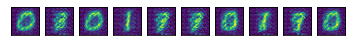

Epoch: [69] [  50/ 200] D_loss: 4.83151293, G_loss: 0.59357888
Epoch: [69] [ 100/ 200] D_loss: 2.28151321, G_loss: 0.71632856
Epoch: [69] [ 150/ 200] D_loss: 1.94188368, G_loss: 0.76172864
Epoch: [69] [ 200/ 200] D_loss: 2.18572664, G_loss: 0.86504745


<Figure size 72x720 with 0 Axes>

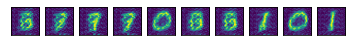

Epoch: [70] [  50/ 200] D_loss: 1.77630198, G_loss: 0.81124675
Epoch: [70] [ 100/ 200] D_loss: 1.62217331, G_loss: 0.75479722
Epoch: [70] [ 150/ 200] D_loss: 2.20463037, G_loss: 0.70689660
Epoch: [70] [ 200/ 200] D_loss: 2.05817008, G_loss: 0.84131181


<Figure size 72x720 with 0 Axes>

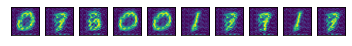

Epoch: [71] [  50/ 200] D_loss: 1.90754032, G_loss: 0.90899205
Epoch: [71] [ 100/ 200] D_loss: 2.39782953, G_loss: 0.85634899
Epoch: [71] [ 150/ 200] D_loss: 2.47040653, G_loss: 0.87132221
Epoch: [71] [ 200/ 200] D_loss: 2.08882499, G_loss: 0.76581842
Training at Epoch:
70


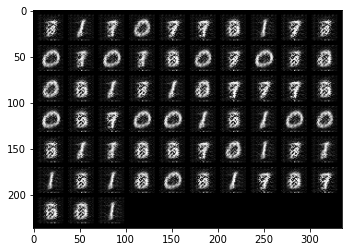

outputs:  torch.Size([10, 10])
	 tensor([[27.9045,  5.4086,  5.6089,  0.0000,  0.0000,  0.0000,  0.0000,  0.3181,
          0.0000,  0.0000],
        [ 7.0607,  0.0000,  0.0000,  0.0000,  0.2442,  0.0000,  3.2137,  0.0000,
          9.5090,  0.0000],
        [ 0.0000,  0.0000,  5.7934,  0.5080,  0.0000,  0.0000,  0.0000,  3.8451,
          3.3910,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 20.1181,
          0.0000,  9.7725],
        [ 0.0000,  0.0000,  0.7507,  3.5873,  0.0000,  0.0000,  1.8113,  0.0000,
          6.8612,  0.0000],
        [ 0.0000,  0.0000,  8.2782,  0.7213,  0.0000,  0.0000,  0.0000,  0.0000,
          4.8125,  0.0000],
        [ 0.0000,  0.0000,  0.4673,  3.1836,  0.0000,  0.0000,  1.9795,  0.0000,
          6.6964,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  2.4202,  0.0000,  3.1098,  6.1289,  0.0000,
          7.1744,  0.0000],
        [ 0.0000,  2.7900,  0.0000,  4.5748,  0.0000,  1.3875,  0.0000, 17.4524,
          0.00

<Figure size 72x720 with 0 Axes>

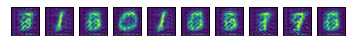

Epoch: [72] [  50/ 200] D_loss: 2.61023164, G_loss: 0.74724883
Epoch: [72] [ 100/ 200] D_loss: 2.55850148, G_loss: 0.83164108
Epoch: [72] [ 150/ 200] D_loss: 3.35539722, G_loss: 0.88604915
Epoch: [72] [ 200/ 200] D_loss: 2.70900154, G_loss: 0.90630847


<Figure size 72x720 with 0 Axes>

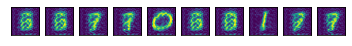

Epoch: [73] [  50/ 200] D_loss: 3.86049509, G_loss: 0.83144289
Epoch: [73] [ 100/ 200] D_loss: 2.62404442, G_loss: 0.88440257
Epoch: [73] [ 150/ 200] D_loss: 1.95076621, G_loss: 0.79057622
Epoch: [73] [ 200/ 200] D_loss: 2.21106148, G_loss: 0.78176546


<Figure size 72x720 with 0 Axes>

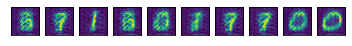

Epoch: [74] [  50/ 200] D_loss: 3.98743868, G_loss: 0.85476470
Epoch: [74] [ 100/ 200] D_loss: 2.54850292, G_loss: 0.85524249
Epoch: [74] [ 150/ 200] D_loss: 3.06672668, G_loss: 0.89876533
Epoch: [74] [ 200/ 200] D_loss: 2.75594401, G_loss: 0.83744162


<Figure size 72x720 with 0 Axes>

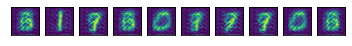

In [ ]:
params = {'beta1': 0.5, 'beta2': 0.9,'lr_g':0.002,'lr_d':0.002,'max_epochs':150}

params['z_dim'] = 1
params['base_size'] = 64

gan = GAN(params)


gan.train()